# PLSR model of MAPK inhibitor-induced changes in differentiation states based on AP-1 dynamics

In [1]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import LeaveOneOut
import copy
import colorcet as cc
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
%matplotlib inline
sns.set(rc={"figure.dpi":100, 'savefig.dpi':100})
sns.set_context('notebook')
sns.set_style("ticks")

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

/var/folders/3b/53nb685n5xn04t6tqf7jb0740000gn/T/xpython_84903/2061031842.py:21: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


## 1. Read data

In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv('Drug_Treatment_Bulk_Normalized_Measurements_for_PLSR.csv')

metadata_names = ["cellline","condition"]

#Drug-induced changes in differentiation state (DMSO normalized de-differentiation score) at 72h upon drug treatment
y_names = np.array(['72 h_dediff']) #72 h_log(NGFR/MITF)

#DMSO-normalized AP-1 level at 24 h upon MAPK inhibitor treatment
x_dmso_norm_24h_names = ['24 h_cFos', '24 h_Phospho_cFos', '24 h_Fra1', '24 h_Phospho_Fra1',
       '24 h_Fra2', '24 h_cJun', '24 h_Phospho_cJun', '24 h_JunB', '24 h_JunD',
       '24 h_Phospho_ATF1', '24 h_ATF2', '24 h_Phospho_ATF2', '24 h_ATF3',
       '24 h_ATF4', '24 h_Phospho_ATF4', '24 h_ATF5', '24 h_ATF6']
#DMSO-normalized AP-1 level at 72 h upon MAPK inhibitor treatment
x_dmso_norm_72h_names = ['72 h_cFos', '72 h_Phospho_cFos', '72 h_Fra1', '72 h_Phospho_Fra1',
       '72 h_Fra2', '72 h_cJun', '72 h_Phospho_cJun', '72 h_JunB', '72 h_JunD',
       '72 h_Phospho_ATF1', '72 h_ATF2', '72 h_Phospho_ATF2', '72 h_ATF3',
       '72 h_ATF4', '72 h_Phospho_ATF4', '72 h_ATF5', '72 h_ATF6']

In [3]:
# input---
selected_x_columns = np.concatenate([x_dmso_norm_24h_names,x_dmso_norm_72h_names])
X = data[selected_x_columns]
Y = data[y_names]

#z-score
Xz = StandardScaler().fit_transform(X)
Yz = StandardScaler().fit_transform(Y)

## 2. Train model

In [4]:
#Full Model R2
r2_scores = list()
for k in np.arange(len(X.columns))+1:
    pls = PLSRegression(n_components=k)
    # fit model
    pls.fit(Xz, Yz)
    # evaluate model
    Yhat = pls.predict(Xz)
    # store
    r2_score = explained_variance_score(Yz, Yhat)
    #r2_score = explained_variance_score(Yz, Yhat,multioutput='uniform_average')
    r2_scores.append(r2_score)
    
#Leave one Out Q2
q2_scores = list()
for k in np.arange(len(X.columns))+1:
    pls = PLSRegression(n_components=k)
    
 
    loo = LeaveOneOut()
    Y_pred = list()

    for train_ix, test_ix in loo.split(Xz):
        # split data
        X_train, X_test = Xz[train_ix, :], Xz[test_ix, :]
        Y_train, Y_test = Yz[train_ix,:], Yz[test_ix,:]
        
        # fit model
        pls.fit(X_train, Y_train)
        # evaluate model
        Yhat = pls.predict(X_test)
        # store
        Y_pred.append(Yhat[0,:])
    q2_score = explained_variance_score(Yz, Y_pred)
    #q2_score = explained_variance_score(Yz, Y_pred,multioutput='uniform_average')
    q2_scores.append(q2_score)

In [5]:
#save 
model_performance = pd.DataFrame({'r2':r2_scores,'q2':q2_scores})
model_performance.to_csv('MAPKi_PLSR_Model_Performance.csv')

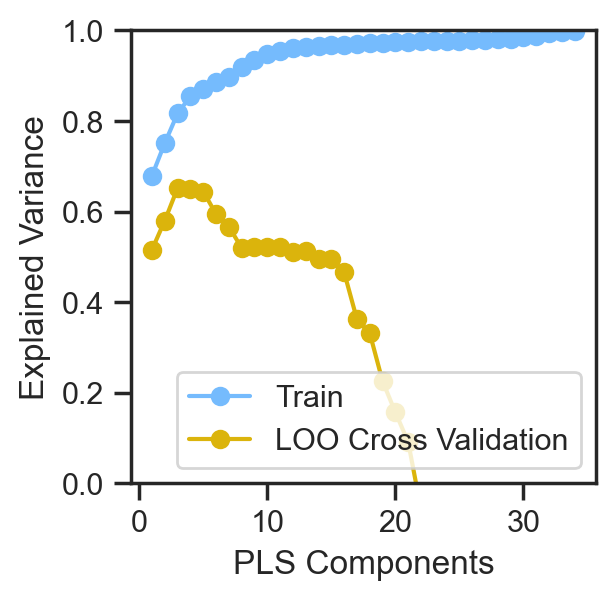

In [6]:
plt.figure(figsize=(3,3))
plt.plot(np.arange(len(X.columns))+1, r2_scores,'-o',color = 'xkcd:sky blue',label='Train')
plt.plot(np.arange(len(X.columns))+1, q2_scores,'-o',color = 'xkcd:gold',label='LOO Cross Validation')

plt.ylim([0,1])
plt.xlabel("PLS Components")
plt.ylabel("Explained Variance")

plt.legend(loc = 'lower right')

opt_ncomp = 3 #optimal number of PLS components chosen

plt.savefig('MAPKi_PLSR_Model_Performance.pdf', format='pdf')

## 3. Leave one out prediction

In [7]:

pls = PLSRegression(n_components=opt_ncomp) #use the optimal number of PLS

loo = LeaveOneOut()
Y_pred = list()

for train_ix, test_ix in loo.split(Xz):
    # split data
    X_train, X_test = Xz[train_ix, :], Xz[test_ix, :]
    Y_train, Y_test = Yz[train_ix,:], Yz[test_ix,:]

    # fit model
    pls.fit(X_train, Y_train)
    # evaluate model
    Yhat = pls.predict(X_test)
    # store
    Y_pred.append(Yhat[0,:])


df_Y_pred = pd.DataFrame(Y_pred,columns = Y.columns)
df_Yz = pd.DataFrame(Yz,columns = Y.columns)

#save
df_Y_pred['cell_line'] = data['cellline']
df_Y_pred['condition'] = data['condition']
df_Y_pred.to_csv('MAPKi_PLSR_LOO_Prediction_Output.csv')

### 4. Variable Importance in Projection Scores

In [8]:
#Calculate VIP scores for each y-response:
def vip(model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_
    
    p, h = w.shape
    k,_ = q.shape
    
    vips = np.zeros((p,k))
    
    for r in range(k):
        
        sr = np.diag(t.T @ t @ (q[r,None].T@q[r,None])).reshape(h, -1)
        total_s = np.sum(sr)
    
        for i in range(p):
            weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
            vips[i,r] = np.sqrt(p*(sr.T @ weight)/total_s)
            
    return vips

In [9]:

final_model = PLSRegression(n_components=opt_ncomp)
final_model.fit(Xz,Yz)
df_vip = pd.DataFrame(data = vip(final_model).T, columns = selected_x_columns, index = y_names)
df_vip



,24 h_cFos,24 h_Phospho_cFos,24 h_Fra1,24 h_Phospho_Fra1,24 h_Fra2,24 h_cJun,24 h_Phospho_cJun,24 h_JunB,24 h_JunD,24 h_Phospho_ATF1,...,72 h_JunB,72 h_JunD,72 h_Phospho_ATF1,72 h_ATF2,72 h_Phospho_ATF2,72 h_ATF3,72 h_ATF4,72 h_Phospho_ATF4,72 h_ATF5,72 h_ATF6
72 h_dediff,0.468051,0.62898,0.656506,0.62698,0.581852,1.779184,1.238007,0.659664,1.086414,0.671525,...,1.069343,1.1633,1.147749,1.273233,0.860727,0.326812,0.984889,0.427004,0.875318,1.368444


In [10]:
from scipy.stats import pearsonr
sign_mat = np.zeros((len(y_names),len(selected_x_columns)))

for i in selected_x_columns:
    for j in y_names:
        data1 = data[i]
        data2 = data[j]
        corr,p = pearsonr(data1, data2)
        print(i, corr,p)
        ii = np.where(selected_x_columns==i)
        jj = np.where(y_names==j)
        
        sign_mat[jj,ii] = np.sign(corr)

        
df_vip_signed = pd.DataFrame(data = vip(final_model).T*sign_mat, columns = selected_x_columns, index = y_names)
df_vip_signed.to_csv('MAPKi_PLSR_signed_VIP.csv')
df_vip_signed


24 h_cFos 0.06292764246613834 0.7154080747085152
24 h_Phospho_cFos 0.18558946699041218 0.2785036518951285
24 h_Fra1 -0.27150984240577636 0.10919525362693648
24 h_Phospho_Fra1 -0.21695137388748498 0.20373913878758843
24 h_Fra2 0.13259640799182845 0.4407576498473168
24 h_cJun 0.7271548606467042 5.086288064710447e-07
24 h_Phospho_cJun 0.48109414481350876 0.0029749025112468745
24 h_JunB -0.20156052770052174 0.23846630611179492
24 h_JunD -0.44041709228344916 0.007184019818032824
24 h_Phospho_ATF1 -0.19979958562464606 0.24267938245186854
24 h_ATF2 -0.4468427178177471 0.00629337317266444
24 h_Phospho_ATF2 0.15671177782311196 0.3613771447137182
24 h_ATF3 -0.11542375317313366 0.5026363163307042
24 h_ATF4 -0.5177159634579201 0.0012213712074919706
24 h_Phospho_ATF4 0.090238955159987 0.6006990595943642
24 h_ATF5 -0.18493775832121037 0.28022493850612434
24 h_ATF6 -0.4327968477839592 0.008378278735955843
72 h_cFos -0.1891750694335445 0.26915650343523395
72 h_Phospho_cFos -0.10027779875248097 0.56063

,24 h_cFos,24 h_Phospho_cFos,24 h_Fra1,24 h_Phospho_Fra1,24 h_Fra2,24 h_cJun,24 h_Phospho_cJun,24 h_JunB,24 h_JunD,24 h_Phospho_ATF1,...,72 h_JunB,72 h_JunD,72 h_Phospho_ATF1,72 h_ATF2,72 h_Phospho_ATF2,72 h_ATF3,72 h_ATF4,72 h_Phospho_ATF4,72 h_ATF5,72 h_ATF6
72 h_dediff,0.468051,0.62898,-0.656506,-0.62698,0.581852,1.779184,1.238007,-0.659664,-1.086414,-0.671525,...,-1.069343,-1.1633,-1.147749,-1.273233,0.860727,0.326812,-0.984889,0.427004,-0.875318,-1.368444


In [11]:
# write results to csv
pls = PLSRegression(n_components=opt_ncomp)
pls.fit(Xz,Yz)
pc_list = ["PC %d"%x for x in np.arange(pls.x_scores_.shape[1])+1]

#Scores
df_xscores = pd.DataFrame(pls.x_scores_)
df_xscores.columns = pc_list
df_xscores['Data.Type'] = "x_score"
df_xscores['Cell Line'] = data['cellline']
df_xscores['Condition'] = data['condition']
df_xscores = pd.concat([df_xscores, Y],axis = 1)

df_xscores_scaled = copy.copy(df_xscores)
for pc in pc_list:
    df_xscores_scaled[pc] = df_xscores_scaled[pc]/(df_xscores_scaled[pc].max()-df_xscores_scaled[pc].min())
df_xscores_scaled['Data.Type'] = "x_score_scaled"

df_yscores = pd.DataFrame(pls.y_scores_)
df_yscores.columns = pc_list
df_yscores['Data.Type'] = "y_score"
df_yscores['Cell Line'] = data['cellline']
df_yscores['Condition'] = data['condition']
df_yscores = pd.concat([df_yscores, Y],axis = 1)

df_yscores_scaled = copy.copy(df_yscores)
for pc in pc_list:
    df_yscores_scaled[pc] = df_yscores_scaled[pc]/(df_yscores_scaled[pc].max()-df_yscores_scaled[pc].min())
df_yscores_scaled['Data.Type'] = "y_score_scaled"

#save
df_scores = pd.concat([df_xscores,df_xscores_scaled,df_yscores,df_yscores_scaled])
#df_scores.to_csv('MAPKi_PLSR_Scores.csv')

#Loadings
df_xloadings = pd.DataFrame(pls.x_loadings_)
df_xloadings.columns = pc_list
df_xloadings['Data.Type'] = "x_loading"
df_xloadings.index = X.columns

df_yloadings = pd.DataFrame(pls.y_loadings_)
df_yloadings.columns = pc_list
df_yloadings['Data.Type'] = "y_loading"
df_yloadings.index = Y.columns

df_xloadings['AP-1'] = X.columns
df_yloadings['Differentiation Signature'] = Y.columns


#save
df_loadings = pd.concat([df_xloadings,df_yloadings])
df_loadings.to_csv('MAPKi_PLSR_Loadings.csv')